In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sympy as sp
import matplotlib.gridspec as gridspec
import random
from importlib import reload # python 2.7 does not require this
import models
reload(models)
from models import FNOProjected, ml_predictor_rnn
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch
import time
from tabulate import tabulate

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
/home/luke/miniconda3/lib/python3.12/site-packages/torch/__init__.py:1240: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [22]:
def dynamics(state, control):
    return np.array([control[0]*math.cos(state[2]), control[0]*math.sin(state[2]), control[1]])

def controller(state, t):
    p = state[0]*math.cos(state[2])+state[1]*math.sin(state[2])
    q = state[0]*math.sin(state[2])-state[1]*math.cos(state[2])
    omega = -5*p**2*math.cos(3*t) - p*q*(1+25*math.cos(3*t)*math.cos(3*t))-state[2]
    nu = -p+5*q*math.sin(3*t)-math.cos(3*t) + q*omega
    return np.array([nu, omega])

def predictor_const_delay(cur_state, control_history, D, x):
    nx = len(x)
    integral_tmp = np.zeros((nx, 3))
    res = np.zeros((nx, 3))
    res[0] = np.copy(cur_state)
    for i in range(1, nx):
        integral_tmp[i] = dynamics(res[i-1], control_history[i-1]) 
        res[i] = res[0] + D*np.array([np.trapz(integral_tmp[0:i+1, 0], x=x[0:i+1]), \
                                      np.trapz(integral_tmp[0:i+1, 1], x=x[0:i+1]),\
                                      np.trapz(integral_tmp[0:i+1, 2], x=x[0:i+1])])
    return res

def predictor_non_const_delay(cur_state, control_history, D, x):
    nx = len(x)
    integral_tmp = np.zeros((nx, 3))
    res = np.zeros((nx, 3))
    res[0] = np.copy(cur_state)
    for i in range(1, nx):
        integral_tmp[i] = dynamics(res[i-1], control_history[i-1]) 
        res[i] = res[0] + D*np.array([np.trapz(integral_tmp[0:i+1, 0], x=x[0:i+1]), \
                                      np.trapz(integral_tmp[0:i+1, 1], x=x[0:i+1]),\
                                      np.trapz(integral_tmp[0:i+1, 2], x=x[0:i+1])])
    return res

def simulate_system(init_cond, dt, T):
    t = np.arange(0, T, dt)
    u = np.zeros((len(t), 3))
    u[0] = init_cond
    controls = np.zeros((len(t), 2))
    for i in range(1, len(t)):
        control = controller(u[i-1], t[i-1])
        u[i] = u[i-1] + dt*dynamics(u[i-1], control)
        controls[i] = control
    return u, controls

def simulate_system_const_delay(init_cond, dt, T, dx, D):
    t = np.arange(0, T, dt)
    x = np.arange(0, 1, dx)
    nx = len(x)
    nt = len(t)
    u = np.zeros((nt, 3))
    pde_sol = np.zeros((nt, nx, 2))
    controls = np.zeros((nt, 2))
    predictions = np.zeros((nt, nx, 3))
    u[0] = init_cond
    for i in range(1, nt):
        prediction = predictor_const_delay(u[i-1], pde_sol[i-1], D, x)
        predictions[i-1] = prediction
        pde_sol[i][0:nx-1] = pde_sol[i-1][0:nx-1] + dt/(D*dx) * (pde_sol[i-1][1:nx] - pde_sol[i-1][0:nx-1])
        pde_sol[i][-1] = controller(prediction[-1], t[i-1]+D)
        u[i] = u[i-1] + dt*dynamics(u[i-1], pde_sol[i][0])
        controls[i] = pde_sol[i][0]
    return u, controls, pde_sol, predictions

def simulate_system_const_delay_neural_op(init_cond, dt, T, dx, D, model, predictor_func):
    t = np.arange(0, T, dt)
    x = np.arange(0, 1, dx)
    nx = len(x)
    nt = len(t)
    u = np.zeros((nt, 3))
    pde_sol = np.zeros((nt, nx, 2))
    controls = np.zeros((nt, 2))
    predictions = np.zeros((nt, nx, 3))
    u[0] = init_cond
    for i in range(1, nt):
        prediction = predictor_func(u[i-1], pde_sol[i-1], D, x, model)
        predictions[i-1] = prediction
        pde_sol[i][0:nx-1] = pde_sol[i-1][0:nx-1] + dt/(D*dx) * (pde_sol[i-1][1:nx] - pde_sol[i-1][0:nx-1])
        pde_sol[i][-1] = controller(prediction[-1], t[i-1]+D)
        u[i] = u[i-1] + dt*dynamics(u[i-1], pde_sol[i][0])
        controls[i] = pde_sol[i][0]
    return u, controls, pde_sol, predictions

def simulate_system_non_const_delay(init_cond, dt, T, dx, delay_funcs, args):
    phi_inv, phi_inv_deriv = delay_funcs[0], delay_funcs[1]
    t = np.arange(0, T, dt)
    x = np.arange(0, 1, dx)
    nx = len(x)
    nt = len(t)
    u = np.zeros((nt, 3))
    pde_sol = np.zeros((nt, nx, 2))
    controls = np.zeros((nt, 2))
    predictions = np.zeros((nt, nx, 3))
    delays = np.zeros((nt))
    u[0] = init_cond
    for i in range(1, nt):
        prediction = predictor_non_const_delay(u[i-1], pde_sol[i-1], phi_inv(t[i-1], args[0], args[1])-t[i-1], x)
        predictions[i-1] = prediction
        delays[i-1] = phi_inv(t[i-1], args[0], args[1])-t[i-1]
        pi = (1+x[0:nx-1]*(phi_inv_deriv(t[i-1], args[0], args[1])-1)/(phi_inv(t[i-1], args[0], args[1])-t[i-1]))
        pde_sol[i][0:nx-1] = pde_sol[i-1][0:nx-1] + dt/dx * np.tile(pi[:, np.newaxis], (1, 2))\
                                                             *(pde_sol[i-1][1:nx] - pde_sol[i-1][0:nx-1])
        pde_sol[i][-1] = controller(prediction[-1], t[i-1]+D)
        u[i] = u[i-1] + dt*dynamics(u[i-1], pde_sol[i][0])
        controls[i] =  pde_sol[i][0]
    return u, controls, pde_sol, predictions, delays

def simulate_system_non_const_delay_neural_op(init_cond, dt, T, dx, delay_funcs, args, model, predictor_func):
    phi_inv, phi_inv_deriv = delay_funcs[0], delay_funcs[1]
    t = np.arange(0, T, dt)
    x = np.arange(0, 1, dx)
    nx = len(x)
    nt = len(t)
    u = np.zeros((nt, 3))
    pde_sol = np.zeros((nt, nx, 2))
    controls = np.zeros((nt, 2))
    predictions = np.zeros((nt, nx, 3))
    delays = np.zeros((nt))
    u[0] = init_cond
    for i in range(1, nt):
        prediction = predictor_func(u[i-1], pde_sol[i-1], phi_inv(t[i-1], args[0], args[1])-t[i-1], x, model)
        predictions[i-1] = prediction
        delays[i-1] = phi_inv(t[i-1], args[0], args[1])-t[i-1]
        pi = (1+x[0:nx-1]*(phi_inv_deriv(t[i-1], args[0], args[1])-1)/(phi_inv(t[i-1], args[0], args[1])-t[i-1]))
        pde_sol[i][0:nx-1] = pde_sol[i-1][0:nx-1] + dt/dx * np.tile(pi[:, np.newaxis], (1, 2))\
                                                             *(pde_sol[i-1][1:nx] - pde_sol[i-1][0:nx-1])
        pde_sol[i][-1] = controller(prediction[-1], t[i-1]+D)
        u[i] = u[i-1] + dt*dynamics(u[i-1], pde_sol[i][0])
        controls[i] =  pde_sol[i][0]
    return u, controls, pde_sol, predictions, delays

In [44]:
init_cond = [1, 1, 1]
dt = 0.01
T = 10
D = 1
dx = 0.01
args = [1, 2]

# Define the symbolic variable
t, a, b = sp.symbols('t a b')

# Define the original symbolic expression
#phi_inv_expr = -1/(2*b)*(1-a-b*t) + sp.sqrt((t+1)/b + 1/(4*b**2)*(1-a-b*t)**2)
phi_inv_expr = t + (t + 1) / (sp.sqrt((t + 1)**2 + 1) + t)


# Compute the symbolic derivative
phi_inv_derivative_expr = sp.diff(phi_inv_expr, t)

# Convert both expressions into callable functions
phi_inv = sp.lambdify((t, a, b), phi_inv_expr, modules=['numpy'])
phi_inv_deriv = sp.lambdify((t, a, b), phi_inv_derivative_expr, modules=['numpy'])    

#u, control = simulate_system(init_cond, dt, T)
#u_delay, control_delay, _, _ = simulate_system_const_delay(init_cond, dt, T, dx, D)
u_non_const_delay, control_non_const_delay, _, _, _ = simulate_system_non_const_delay(init_cond, dt, T, dx, (phi_inv, phi_inv_deriv), args)

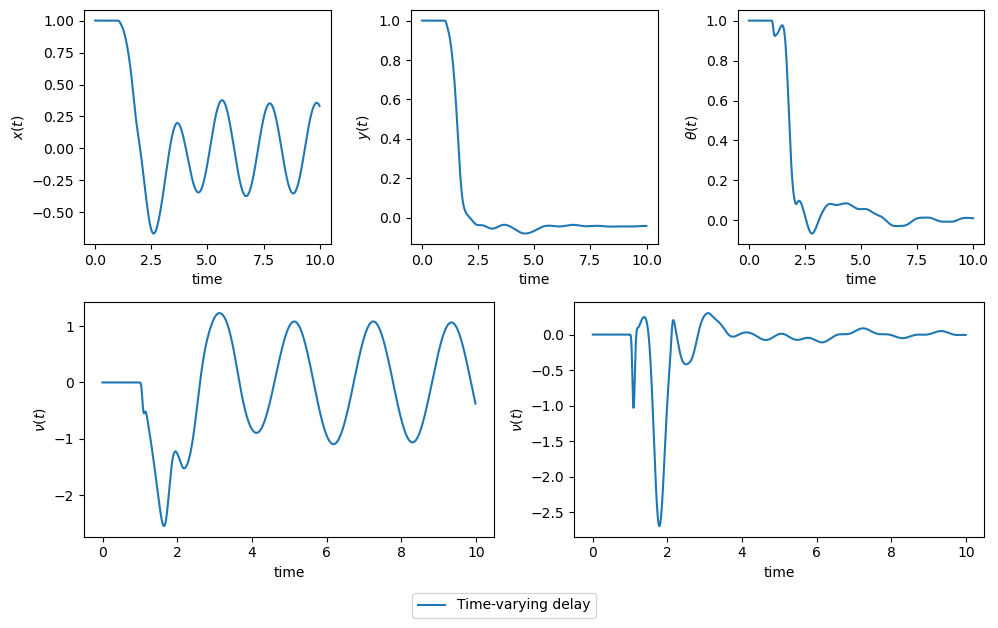

In [45]:
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 6, height_ratios=[1, 1])  # 2 rows, 3 columns

ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])

ax4 = fig.add_subplot(gs[1, 0:3])  # Spans columns 0 and 1
ax5 = fig.add_subplot(gs[1, 3:6])    # Just column 2

t = np.arange(0, T, dt)

ax1.plot(t, u_non_const_delay[:, 0], label="Time-varying delay")
ax1.set_ylabel(r"$x(t)$")
ax1.set_xlabel("time")

ax2.plot(t, u_non_const_delay[:, 1], label="Time-varying delay")
ax2.set_ylabel(r"$y(t)$")
ax2.set_xlabel("time")


ax3.plot(t,u_non_const_delay[:, 2], label="Time-varying delay")
ax3.set_xlabel("time")
ax3.set_ylabel(r"$\theta(t)$")

ax4.plot(t,control_non_const_delay[:, 0], label="Time-varying delay")
ax4.set_xlabel("time")
ax4.set_ylabel(r"$\nu(t)$")


l2, = ax5.plot(t, control_non_const_delay[:, 1], label="Time-varying delay")
ax5.set_xlabel("time")
ax5.set_ylabel(r"$\nu(t)$")

# Horizontal legend below all plots
fig.legend(handles=[l2],
           loc='lower center',
           ncol=3,
           fontsize=10,
           frameon=True,
           fancybox=True,
           shadow=False,
           bbox_to_anchor=(0.5, -0.05))  # Adjust this to fine-tune spacing

plt.tight_layout(rect=[0, 0.08, 1, 1])  # Leave space at bottom for legend 

plt.tight_layout()

In [58]:
# Build a dataset for unicycle for Time-varying delay. Vary over both initial conditions and delay
num_trajs = 100
sample_rate = 200
dt = 0.01
T = 10
D = 1
dx = 0.01
x = np.arange(0, 1, dx)
nx = len(x)
t = np.arange(0, T, dt)
nt = len(t)
index = 0

inputs = np.zeros((num_trajs*sample_rate, nx, 6))
outputs = np.zeros((num_trajs*sample_rate, nx, 3))
for i in range(num_trajs):
    if i % 5 == 0:
        print(i)
    init_cond = np.array([1, 1, 1]) + np.random.uniform(-0.1, 0.1, size=3)
    b = np.random.uniform(2, 2.1, size=1)
    u_delay, control_delay, pde, predictions, delay_vals = simulate_system_non_const_delay(init_cond, dt, T, dx, [phi_inv, phi_inv_deriv], (1, b[0]))
    sample_locs = random.sample(range(0, nt), sample_rate)
    for sample in sample_locs:
        my_delays = np.full(nx, delay_vals[sample]).reshape(nx, 1)
        states = np.tile(u_delay[sample], (nx, 1))
        inputs[index] = np.hstack([my_delays, states, pde[sample]])
        outputs[index] = predictor_non_const_delay(u_delay[sample], pde[sample], my_delays[0], x)
        index += 1

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


In [59]:
np.save('inp_dataset_non_const.npy', inputs)
np.save('out_dataset_non_const.npy', outputs)

In [60]:
batch_size=128

In [61]:
inputs = np.load("inp_dataset_non_const.npy").astype(np.float32)
outputs = np.load("out_dataset_non_const.npy").astype(np.float32)

x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_train = torch.from_numpy(y_train).cuda()
y_test = torch.from_numpy(y_test).cuda()
torch.optim.lr_scheduler.ExponentialLR
trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True, generator=torch.Generator(device="cuda"))
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False, generator=torch.Generator(device="cuda"))

In [62]:
def model_trainer(model, trainData, testData, num_epochs, batch_size, gamma, learning_rate, weight_decay):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    loss = torch.nn.MSELoss(reduction="mean")
    best_test_loss = np.inf
    train_lossArr = []
    test_lossArr = []
    time_Arr = []
    print("Epoch", "Time", "Train Loss", "Test Loss")
    print("Total epochs", num_epochs)
    for ep in range(num_epochs):
        model.train()
        t1 = time.time()
        train_loss = 0
        for x_vals, y_vals in trainData:
            optimizer.zero_grad()
            out = model(x_vals)
        
            lp = loss(out, y_vals) 
            lp.backward()
            
            optimizer.step()
            train_loss += lp.item()
            
        scheduler.step()
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for x_vals, y_vals in testData:
                out = model(x_vals)
                test_loss += loss(out, y_vals).item() 

        train_loss /= len(trainData)
        test_loss /= len(testData)
        
        train_lossArr.append(train_loss)
        test_lossArr.append(test_loss)
        
        t2 = time.time()
        time_Arr.append(t2-t1)
        if ep%5 == 0:
            print(ep, t2-t1, train_loss, test_loss)

        if test_loss <= best_test_loss:
            bestModelDict = model.state_dict()
            best_test_loss = test_loss
    torch.save(bestModelDict,"myModel")
    return model, train_lossArr, test_lossArr
    
def evaluate_model(model, name, train_lossArr, test_lossArr):
    print("Evaluating model", name)
    # Display Model Details
    plt.figure()
    plt.title("Loss function "+name)
    plt.plot(train_lossArr, label="Train Loss")
    plt.plot(test_lossArr, label="Test Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()
    plt.savefig("losscurve.pdf")
        
    print("Final Testing Loss:", test_lossArr[-1])
    print("Final Training Loss:", train_lossArr[-1])

In [67]:
model = FNOProjected(16,2, 12,6,3)

Epoch Time Train Loss Test Loss
Total epochs 50
0 0.7775628566741943 0.04224779090269449 0.011434953252319247
5 0.7065176963806152 0.0012080449072630905 0.0011049820241169073
10 0.6431810855865479 0.0004009589159048777 0.0004003881840617396
15 0.6226859092712402 0.0002821003549636494 0.0002808602603181498
20 0.6360988616943359 0.00022998097037288842 0.0002242063928861171
25 0.6402812004089355 0.00019818690660366697 0.0001999250334847602
30 0.6190030574798584 0.00017591639757709551 0.0001771864344846108
35 0.6371285915374756 0.00016134235502636814 0.00016110071146613336
40 0.6091232299804688 0.00015076223654748462 0.00014934728415028076
45 0.6112065315246582 0.0001430262895903702 0.00014202620013747946
Evaluating model FNO


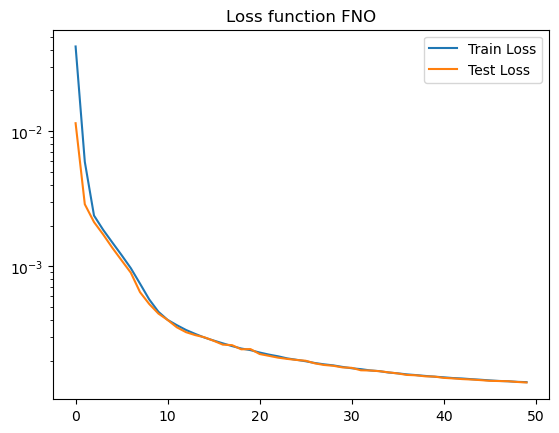

Final Testing Loss: 0.00013806833521812223
Final Training Loss: 0.00013886161380965948


<Figure size 640x480 with 0 Axes>

In [68]:
batch_size=64
gamma=0.93
lr=1e-3
decay=1e-4
epochs=50
model, trainLoss, testLoss = model_trainer(model, trainData, testData, epochs, batch_size, gamma, lr, decay)
evaluate_model(model, "FNO", trainLoss, testLoss)

In [69]:
init_cond = [1,1,1]
dt = 0.01
T = 10
D = 1
dx = 0.01
args = (1, 2)

from importlib import reload # python 2.7 does not require this
import models
reload(models)
from models import FNOProjected, ml_predictor_rnn

u_non_const_delay, control_non_const_delay, _, _, _ = simulate_system_non_const_delay(init_cond, dt, T, dx, (phi_inv, phi_inv_deriv), args)
u_non_const_delay_ml, control_non_const_delay_ml, _, _, _ = simulate_system_non_const_delay_neural_op(init_cond, dt, T, dx, (phi_inv, phi_inv_deriv), args, model,  ml_predictor_rnn)

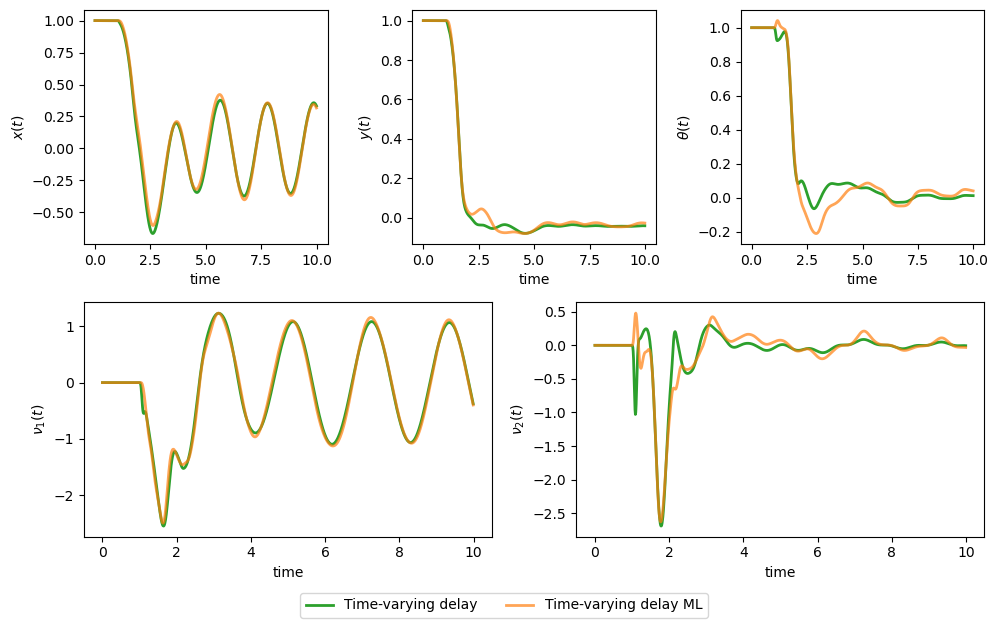

In [70]:
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 6, height_ratios=[1, 1])  # 2 rows, 3 columns

ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])

ax4 = fig.add_subplot(gs[1, 0:3])  # Spans columns 0 and 1
ax5 = fig.add_subplot(gs[1, 3:6])    # Just column 2

t = np.arange(0, T, dt)

style1 = {'color': 'tab:green', 'linestyle': '-', 'linewidth': 2}
style2 = {'color': 'tab:orange', 'linestyle': '-', 'linewidth': 2, 'alpha': 0.7}

ax1.plot(t, u_non_const_delay[:, 0], label="Time-varying delay", **style1)
ax1.plot(t, u_non_const_delay_ml[:, 0], label="Time-varying delay ML", **style2)
ax1.set_ylabel(r"$x(t)$")
ax1.set_xlabel("time")

ax2.plot(t, u_non_const_delay[:, 1], **style1)
ax2.plot(t, u_non_const_delay_ml[:, 1], **style2)
ax2.set_ylabel(r"$y(t)$")
ax2.set_xlabel("time")

ax3.plot(t, u_non_const_delay[:, 2], **style1)
ax3.plot(t, u_non_const_delay_ml[:, 2], **style2)
ax3.set_xlabel("time")
ax3.set_ylabel(r"$\theta(t)$")

ax4.plot(t, control_non_const_delay[:, 0], **style1)
ax4.plot(t, control_non_const_delay_ml[:, 0], **style2)
ax4.set_xlabel("time")
ax4.set_ylabel(r"$\nu_1(t)$")

l1, = ax5.plot(t, control_non_const_delay[:, 1], label="Time-varying delay", **style1)
l2, = ax5.plot(t, control_non_const_delay_ml[:, 1], label="Time-varying delay ML", **style2)
ax5.set_xlabel("time")
ax5.set_ylabel(r"$\nu_2(t)$")

# Add a horizontal legend below all subplots
fig.legend(handles=[l1, l2],
           loc='lower center',
           ncol=3,
           fontsize=10,
           frameon=True,
           fancybox=True,
           shadow=False,
           bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()